In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import json
import itertools
from tqdm import tqdm_notebook
from scipy.spatial.distance import pdist
from sklearn.metrics import precision_recall_curve, auc, f1_score
from Simplex2Vec.utils import read_simplex_json

from kleinberg_experiment import *
plt.style.use('seaborn')

# Upload Kleinberg data into memory

We use the dataset of primary school contacts first (from Sociopatterns). We use the dataset provided by Kleinberg et al. Below we upload the simplices to the memory.

In [2]:
dataset = "email-Enron"
data_dir = "./data/kleinberg/{}/".format(dataset)
simplex_file = "{}-simplices.txt".format(dataset)
size_file = "{}-nverts.txt".format(dataset)

simplexf = open(data_dir + simplex_file, 'r')
sizef = open(data_dir + size_file, 'r')

In [3]:
simplex_sizes = []
for s in tqdm_notebook(sizef):
    ss = s.strip()
    simplex_sizes.append(int(ss))

print("Min simplex size: {}, max simplex_size: {}".format(min(simplex_sizes), max(simplex_sizes)))


Min simplex size: 1, max simplex_size: 18


In [8]:
node_list = set([])
simplex_list = []
exceptions = []
cut_size = 1000000
cut_len_size = 7
for s in tqdm_notebook(simplex_sizes):
    if s <= cut_len_size:
        one_simplex = []
        for i in range(s):
            rl = simplexf.readline()
            n = rl.strip()
            try:
                one_simplex.append(int(n))
                node_list.add(int(n))
            except:
                exceptions.append(rl)
        simplex_list.append(frozenset(one_simplex))
        if len(simplex_list) > cut_size:
            break
print("Exceptions:", len(exceptions))


Exceptions: 0


# Upload our data into memory

In [5]:
in_file = "./data/sociopatterns_facets/aggr_5min_cliques_InVS15.json"

simplex_list = read_simplex_json(in_file)

Kleinberg's sets their experiment as follows. On the first 80% of data they find the set of *open* triangles, i.e. the triangles in the projected graph (the one you obtain by projecting all interactions) which have all edges participating in some cliques, but not all three together in one clique. 

Then on the test set, they make a prediction  which open triangles from the test set will close (there will appear a clique containing this triangle). 

They compare their prediction with random null model, where each clique has independent probability to close which is equal to the number of closed triangles/total number of open triangles. 

The measure they compare is the AUC PR (area under the precision-recall curve), relative to AUC PR of the random null model. 

# Find open triangles

Split the set of all simplices to train set (first 80%) and test set (rest 20%).

In [9]:
threshold = int(0.8*len(simplex_list))
train_simplices = simplex_list[:threshold]
test_simplices = simplex_list[threshold:]

Find all closed and open triangles in the train and test set

In [10]:
g_train = get_projected_graph(train_simplices, info = True)
open_train, closed_train = get_open_closed_triangles(g_train, info = True)


Name: 
Type: Graph
Number of nodes: 142
Number of edges: 1422
Average degree:  20.0282



Open: 3587, Closed: 1271


In [11]:
g_total = get_projected_graph(simplex_list, info = True)
open_total, closed_total = get_open_closed_triangles(g_total, info = True)


Name: 
Type: Graph
Number of nodes: 143
Number of edges: 1632
Average degree:  22.8252



Open: 4671, Closed: 1534


Look which triangles have closed

In [12]:
closed_from_test = [t for t in closed_total if t in open_train]
print(len(closed_from_test))
open_from_test = [t for t in open_total if t in open_train]
print(len(open_from_test))

70
3517


Get the probability vector for null model and y_true for future comparison.

In [13]:
y_true = [1 if t in closed_from_test else 0 for t in open_train]
print(len(y_true))
prediction_null_model = np.asarray([sum(y_true)/len(y_true)]*len(y_true))
print(sum(prediction_null_model))

3587
70.0000000000001


# Simplex2Vec  test

Launch and train the Simplex2Vec model. 

In [29]:
# import clusim.sim as sim
# from clusim.clustering import Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE

from Simplex2Vec.Simplex2Vec import Simplex2Vec
from Simplex2Vec.utils import check_prediction
from Simplex2Vec.utils import read_simplex_json
from Simplex2Vec.simplex2hasse import simplex2hasse_HOexponential

g_hasse = simplex2hasse_HOexponential(train_simplices, max_order = 7)
print(nx.info(g_hasse))


Name: 
Type: Graph
Number of nodes: 3689
Number of edges: 10428
Average degree:   5.6536


In [83]:
s2v = Simplex2Vec.from_hasse_diagram(g_hasse, p = 1, n_walks=5, 
                                     walk_length=60, workers = 5)






DONE!


In [84]:
class EpochShowLoss():
    '''Callback to show training loss after each epoch '''

    def __init__(self):
        self.epoch = 0
    
    def on_train_begin(self, model):
        pass
    def on_train_end(self, model):
        pass
    def on_epoch_begin(self, model):
        pass
    def on_batch_begin(self, model):
        pass
    def on_batch_end(self, model):
        pass
        
    def on_epoch_end(self, model):
        print("Epoch {} - Model loss: {}".format(self.epoch,
                                              model.get_latest_training_loss()))
        model_loss.append((self.epoch, model.get_latest_training_loss()))
        self.epoch += 1
model_loss = []
model = s2v.fit(iter = 1, size=1200, window=6, workers = 5, callbacks = [EpochShowLoss()])
# for _ in range(20):  
#     model = s2v.refit(epochs = 1, callbacks = [EpochShowLoss()])
    

Fitting the Word2Vec..
Epoch 0 - Model loss: 377684.96875


## Plot the embedding

Extract the embedding vectors for nodes or edges and plot it on the plane using tSNE embedding.

In [66]:
X = []
X_labels = []

for u in model.wv.vocab.keys():
    if len(u.split(',')) == 1: # get all embedding vectors 
        X.append(model.wv[u])
        
X_transform = TSNE(n_components=2).fit_transform(X)

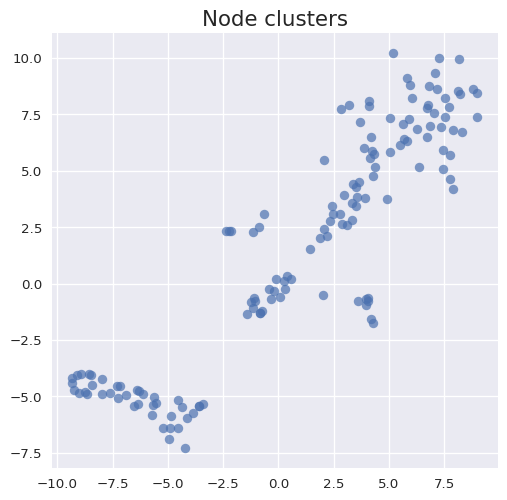

In [67]:
fig = plt.figure(figsize = (6,6), dpi = 96)
# colors_list = cm.nipy_spectral(np.asarray(pred_cluster_labels).astype(float) / num_classes)
plt.scatter(*zip(*X_transform), marker='o', s=50, lw=0, alpha=0.7,)
#                      c = colors_list)
text_params = {'ha': 'center', 'va': 'center', 'family': 'oswald-light',
                   'fontweight': 'normal', "size": 12}
# for i, z in enumerate(Z_labels):
#     x,y = X_transform[i]
#     plt.text(x,y, z, color = "black", alpha=0.8)

plt.title("Node clusters", fontsize = 16)
plt.show()

# Analyze open and closed triangles distance distribution

### Sum of pairwise cosine similarities as a predictor


Histogram of perimeters from already closed triangles


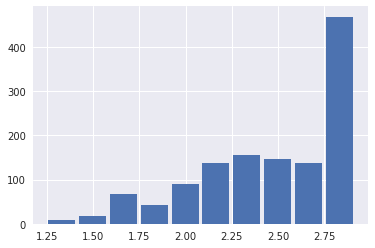

In [68]:
already_closed_triangles_dist = []
for t in tqdm_notebook(closed_train):
    distance_scores = []
    for u,v in itertools.combinations(t,2):
        uf = str(u)
        vf = str(v)
        distance_scores.append(model.wv.similarity(uf,vf))
    already_closed_triangles_dist.append(np.sum(distance_scores))

len(already_closed_triangles_dist)

print('Histogram of perimeters from already closed triangles')
hist, bins = np.histogram(already_closed_triangles_dist, bins = 10)
bin_width = bins[1] - bins[0]
plt.bar(bins[:-1], hist, width = 0.88*bin_width)
plt.show()


70
Histogram of perimeters of future close triangles


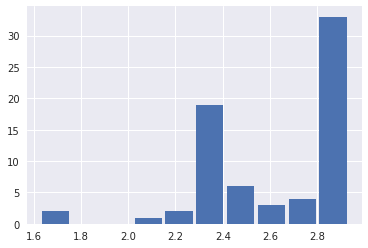

In [69]:
future_close_triangles_dist = []
for t in tqdm_notebook(closed_from_test):
    distance_scores = []
    
    for u,v in itertools.combinations(t,2):
        uf = str(u)
        vf = str(v)
        distance_scores.append(model.wv.similarity(uf,vf))
    future_close_triangles_dist.append(np.sum(distance_scores))

print(len(future_close_triangles_dist))

print('Histogram of perimeters of future close triangles')
hist, bins = np.histogram(future_close_triangles_dist, bins = 10)
bin_width = bins[1] - bins[0]
plt.bar(bins[:-1], hist, width = 0.88*bin_width)
plt.show()


3517
Histogram of perimeters of still open triangles


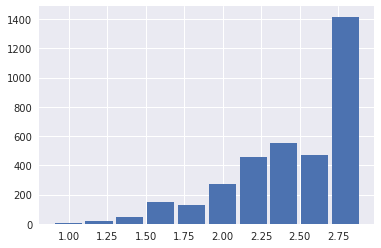

In [70]:
future_open_triangles_dist = []
for t in tqdm_notebook(open_from_test):
    distance_scores = []
    for u,v in itertools.combinations(t,2):
        uf = str(u)
        vf = str(v)
        distance_scores.append(model.wv.similarity(uf,vf))
    future_open_triangles_dist.append(np.sum(distance_scores))

print(len(future_open_triangles_dist))

print('Histogram of perimeters of still open triangles')
hist, bins = np.histogram(future_open_triangles_dist, bins = 10)
bin_width = bins[1] - bins[0]
plt.bar(bins[:-1], hist, width = 0.88*bin_width)
plt.show()

# Scoring the closing triangles - v1

Now we test the predictive model based on cosine similarity. The idea is simple: if an open triangle has all nodes that have high cosine similarity to each other, then this triangle is highly likely to close in future. We use simple sum of all three similarities as a decision function.

In v1 we use the similarity of pairs of nodes in a triangle.

In [71]:
from sklearn.metrics import precision_recall_curve, auc, f1_score
closure_similarity = []
for t in tqdm_notebook(open_train):
    similarity_scores = []
    for u,v in itertools.combinations(t,2):
        uf = str(u)
        vf = str(v)
        similarity_scores.append(model.wv.similarity(uf,vf))
    closure_similarity.append(np.mean(similarity_scores))
  
print(len(closure_similarity))


3587


AUCPR RND: 0.019514914970727628 | AUCPR S2V: 0.03486036619851309
Ratio as in Kleinberg --  AUCPR S2V/AUCPR RND : 1.7863447650580921


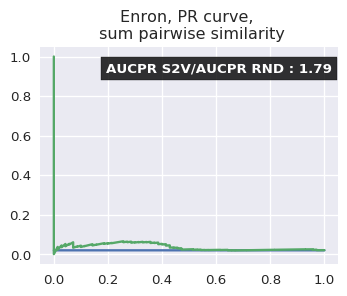

In [72]:
s2v_precision, s2v_recall, _ = precision_recall_curve(y_true, closure_similarity)
null_recall = np.linspace(0,1,len(prediction_null_model))

aucpr_null = auc(null_recall, prediction_null_model)
aucpr_s2v = auc(s2v_recall, s2v_precision)

print("AUCPR RND: {} | AUCPR S2V: {}".format(aucpr_null, aucpr_s2v))
kleinberg_ratio = aucpr_s2v/aucpr_null
print("Ratio as in Kleinberg --  AUCPR S2V/AUCPR RND :", kleinberg_ratio)

plt.figure(figsize = (4,3), dpi = 96)
plt.title("Enron, PR curve, \n sum pairwise similarity")
plt.plot(null_recall, prediction_null_model)
plt.plot(s2v_recall, s2v_precision)

ax = plt.gca()
plt_label = "AUCPR S2V/AUCPR RND : {}".format(round(kleinberg_ratio,2))
text_params = {'ha': 'center', 'va': 'center', 'family': 'sans-serif',
                   'fontweight': 'bold', "size": 10}
plt.text(0.6,0.9, plt_label, color = "white", 
         bbox=dict(facecolor='black', alpha=0.8), transform=ax.transAxes, **text_params)
plt.show()

# Scoring the closing triangles - v3

In v3 we use sum of all average pairwise similarities of simplices that pass through the edges that constitute a triangle. The results a disappointing as well.


3587
Histogram of perimeters of open train triangles


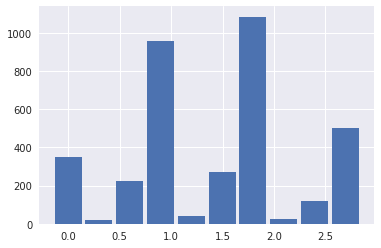

In [73]:
# All open triangles from the train set
from scipy.stats.mstats import gmean
from scipy.stats import hmean

mega_closure_similarity = []
for t in tqdm_notebook(list(open_train)):
    similarity_scores = []
    triangle_edges = [",".join([str(u), str(v)]) for u,v in itertools.combinations(t,2)]

    for u, v in itertools.combinations(list(t),2):
        passing_simplices = g_train[u][v]["simplices"]
        passing_simplices_similarities = []
        for s1,s2 in itertools.combinations(passing_simplices,2):
            s1_int = sorted([int(x) for x in list(s1)])
            s1_model = ",".join([str(x) for x in s1_int])
            s2_int = sorted([int(x) for x in list(s2)])
            s2_model = ",".join([str(x) for x in s2_int])
            sim_score = model.wv.similarity(s1_model,s2_model)
            if sim_score < 0:
                sim_score = 0
            passing_simplices_similarities.append(sim_score)
        if len(passing_simplices_similarities):
            similarity_scores.append(np.mean(passing_simplices_similarities))
        else:
            similarity_scores.append(0)
    mega_closure_similarity.append(np.sum(similarity_scores))
print(len(mega_closure_similarity))

print('Histogram of perimeters of open train triangles')
hist, bins = np.histogram(mega_closure_similarity, bins = 10)
bin_width = bins[1] - bins[0]
plt.bar(bins[:-1], hist, width = 0.88*bin_width)
plt.show()


70
Histogram of perimeters of future close triangles


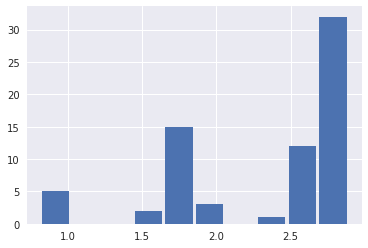

In [74]:
# Only those triangles which further close
future_close_triangles_dist = []
for t in tqdm_notebook(closed_from_test):
    similarity_scores = []
    triangle_edges = [",".join([str(u), str(v)]) for u,v in itertools.combinations(t,2)]
    for u, v in itertools.combinations(list(t),2):
        passing_simplices = g_train[u][v]["simplices"]
        passing_simplices_similarities = []
        for s1,s2 in itertools.combinations(passing_simplices,2):
            s1_int = sorted([int(x) for x in list(s1)])
            s1_model = ",".join([str(x) for x in s1_int])
            s2_int = sorted([int(x) for x in list(s2)])
            s2_model = ",".join([str(x) for x in s2_int])
            passing_simplices_similarities.append(model.wv.similarity(s1_model,s2_model))
        if len(passing_simplices_similarities):
            similarity_scores.append(np.mean(passing_simplices_similarities))
        else:
            similarity_scores.append(0)
    future_close_triangles_dist.append(np.sum(similarity_scores))
print(len(future_close_triangles_dist))

print('Histogram of perimeters of future close triangles')
hist, bins = np.histogram(future_close_triangles_dist, bins = 10)
bin_width = bins[1] - bins[0]
plt.bar(bins[:-1], hist, width = 0.88*bin_width)
plt.show()

Histogram of perimeters of open train triangles
Histogram of perimeters of future close triangles


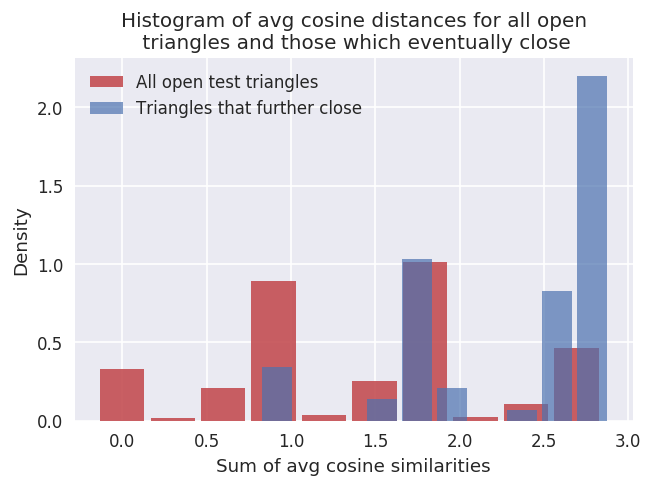

In [75]:
plt.figure(figsize = (6,4), dpi = 120)

print('Histogram of perimeters of open train triangles')
hist, bins = np.histogram(mega_closure_similarity, bins = 10, density=True)
bin_width = bins[1] - bins[0]
plt.bar(bins[:-1], hist, width = 0.88*bin_width, color = "C2", label = "All open test triangles", alpha = 0.9)

print('Histogram of perimeters of future close triangles')
hist, bins = np.histogram(np.array(future_close_triangles_dist), bins = 10, density=True)
bin_width = bins[1] - bins[0]
plt.bar(bins[:-1], hist, width = 0.88*bin_width, color = "C0", label = "Triangles that further close", alpha = 0.7)
plt.legend(loc = "best")
plt.ylabel("Density")
plt.xlabel("Sum of avg cosine similarities")
plt.title("Histogram of avg cosine distances for all open\n triangles and those which eventually close")
plt.show()

AUCPR RND: 0.019514914970727628 | AUCPR S2V: 0.08530588905231568
Ratio as in Kleinberg --  AUCPR S2V/AUCPR RND : 4.3713174861522335


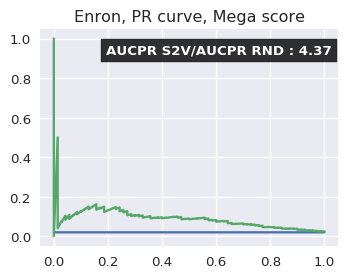

In [76]:
s2v_precision, s2v_recall, _ = precision_recall_curve(y_true, mega_closure_similarity)

null_recall = np.linspace(0,1,len(prediction_null_model))
aucpr_null = auc(null_recall, prediction_null_model)
aucpr_s2v = auc(s2v_recall, s2v_precision)

print("AUCPR RND: {} | AUCPR S2V: {}".format(aucpr_null, aucpr_s2v))
kleinberg_ratio = aucpr_s2v/aucpr_null
print("Ratio as in Kleinberg --  AUCPR S2V/AUCPR RND :", kleinberg_ratio)

plt.figure(figsize = (4,3), dpi = 96)
plt.plot(null_recall, prediction_null_model)
plt.plot(s2v_recall, s2v_precision)
plt.title("Enron, PR curve, Mega score")

ax = plt.gca()
plt_label = "AUCPR S2V/AUCPR RND : {}".format(round(kleinberg_ratio,2))
text_params = {'ha': 'center', 'va': 'center', 'family': 'sans-serif',
                   'fontweight': 'bold', "size": 10}
plt.text(0.6,0.9, plt_label, color = "white", 
         bbox=dict(facecolor='black', alpha=0.8), transform=ax.transAxes, **text_params)

plt.show()

# Kleinberg Geometric mean 

In [81]:
from scipy.stats.mstats import gmean
from scipy.stats import hmean

geom_mean_similarity = []
for t in tqdm_notebook(open_train):
    similarity_scores = []
    for u,v in itertools.combinations(t,2):
        similarity_scores.append(len(g_train[u][v]["simplices"]))
    geom_mean_similarity.append(hmean(similarity_scores))

AUCPR RND: 0.019514914970727628 | AUCPR S2V: 0.06783818647681145
Ratio as in Kleinberg --  AUCPR S2V/AUCPR RND : 3.4762224984617522


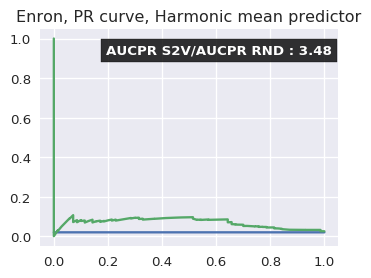

In [82]:
s2v_precision, s2v_recall, _ = precision_recall_curve(y_true, geom_mean_similarity)

null_recall = np.linspace(0,1,len(prediction_null_model))
aucpr_null = auc(null_recall, prediction_null_model)
aucpr_s2v = auc(s2v_recall, s2v_precision)

print("AUCPR RND: {} | AUCPR S2V: {}".format(aucpr_null, aucpr_s2v))
kleinberg_ratio = aucpr_s2v/aucpr_null
print("Ratio as in Kleinberg --  AUCPR S2V/AUCPR RND :", kleinberg_ratio)

plt.figure(figsize = (4,3), dpi = 96)
plt.plot(null_recall, prediction_null_model)
plt.plot(s2v_recall, s2v_precision)
plt.title("Enron, PR curve, Harmonic mean predictor")

ax = plt.gca()
plt_label = "AUCPR S2V/AUCPR RND : {}".format(round(kleinberg_ratio,2))
text_params = {'ha': 'center', 'va': 'center', 'family': 'sans-serif',
                   'fontweight': 'bold', "size": 10}
plt.text(0.6,0.9, plt_label, color = "white", 
         bbox=dict(facecolor='black', alpha=0.8), transform=ax.transAxes, **text_params)

plt.show()

In [53]:
from scipy.stats.mstats import gmean

future_close_geom_mean_similarity = []
for t in tqdm_notebook(closed_from_test):
    similarity_scores = []
    for u,v in itertools.combinations(t,2):
        similarity_scores.append(len(g_train[u][v]["simplices"]))
    future_close_geom_mean_similarity.append(hmean(similarity_scores))

Geometric mean Kleinberg of open train triangles
Geometric mean Kleinberg of future close triangles


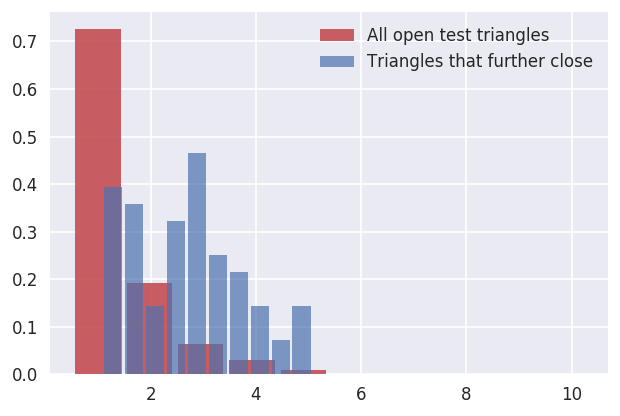

In [54]:
plt.figure(figsize = (6,4), dpi = 120)

print('Geometric mean Kleinberg of open train triangles')
hist, bins = np.histogram(geom_mean_similarity, bins = 10, density=True)
bin_width = bins[1] - bins[0]
plt.bar(bins[:-1], hist, width = 0.88*bin_width, color = "C2", label = "All open test triangles", alpha = 0.9)

print('Geometric mean Kleinberg of future close triangles')
hist, bins = np.histogram(future_close_geom_mean_similarity, bins = 10, density=True)
bin_width = bins[1] - bins[0]
plt.bar(bins[:-1], hist, width = 0.88*bin_width, color = "C0", label = "Triangles that further close", alpha = 0.7)
plt.legend(loc = "best")
plt.show()